In [36]:
# Directories and model path
model_path = 'C:/Users/sakar/mt-3d-environments-from-video/runs/pose/yolov8_final/weights/last.pt'
image_dir = r"C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test"
ground_truth_dir = r"C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\2d_data"
save_dir = r"C:\Users\sakar\OneDrive\mt-datas\Assets for the Report\Results Test"
dataset = "test"
starting_index = 10000
max_files=100

# Euclidian Distance

In [17]:
import os
import pandas as pd
from scipy.spatial.distance import euclidean
from ultralytics import YOLO
from PIL import Image
import numpy as np

def compute_euclidean_distance(row1, row2):
    """
    Computes the Euclidean distance for:
    - Bounding box center (x, y)
    - Bounding box size (x, y)
    - Corners (8 pairs)
    """
    distances = {
        "center": euclidean(row1[1:3], row2[1:3]),
        "size": euclidean(row1[3:5], row2[3:5]),
        "corners": [euclidean(row1[5 + i * 2:7 + i * 2], row2[5 + i * 2:7 + i * 2])
                    for i in range(8)]
    }
    return distances


def find_closest_match(predictions, ground_truth, width, height):
    """
    Finds the closest match for each prediction in the ground truth based on Euclidean distance.
    """
    results = []

    if predictions.empty or ground_truth.empty:
        print("One of the DataFrames is empty, skipping...")
        return results

    try:
        # Group ground truth and predictions by object ID
        gt_groups = ground_truth.groupby(0)
        pred_groups = predictions.groupby(0)

        # Get the intersection of IDs present in both predictions and ground truth
        common_ids = set(gt_groups.groups.keys()) & set(pred_groups.groups.keys())

        for obj_id in common_ids:
            gt_rows = ground_truth.loc[gt_groups.groups[obj_id]].copy()
            pred_rows = predictions.loc[pred_groups.groups[obj_id]].copy()

            # Match predictions and ground truth for this object ID
            while not gt_rows.empty and not pred_rows.empty:
                min_distances = None
                min_gt_index = None
                min_pred_index = None

                # Find the closest ground truth-prediction pair
                for gt_index, gt_row in gt_rows.iterrows():
                    for pred_index, pred_row in pred_rows.iterrows():
                        distances = compute_euclidean_distance(pred_row, gt_row)
                        if min_distances is None or distances["center"] < min_distances["center"]:
                            min_distances = distances
                            min_gt_index = gt_index
                            min_pred_index = pred_index

                # Multiply normalized values by width and height to get non-normalized distances
                pred_row_non_normalized = pred_rows.loc[min_pred_index].copy()
                pred_row_non_normalized[1] *= width
                pred_row_non_normalized[2] *= height
                pred_row_non_normalized[3] *= width
                pred_row_non_normalized[4] *= height
                for i in range(8):
                    pred_row_non_normalized[5 + i * 2] *= width
                    pred_row_non_normalized[6 + i * 2] *= height

                gt_row_non_normalized = gt_rows.loc[min_gt_index].copy()
                gt_row_non_normalized[1] *= width
                gt_row_non_normalized[2] *= height
                gt_row_non_normalized[3] *= width
                gt_row_non_normalized[4] *= height
                for i in range(8):
                    gt_row_non_normalized[5 + i * 2] *= width
                    gt_row_non_normalized[6 + i * 2] *= height

                # Compute non-normalized distances
                non_normalized_distances = compute_euclidean_distance(pred_row_non_normalized, gt_row_non_normalized)

                # Save the closest match
                results.append({
                    "id": obj_id,
                    "min_center_distance_normalized": min_distances["center"],
                    "min_size_distance_normalized": min_distances["size"],
                    "min_corner_distances_normalized": min_distances["corners"],
                    "min_center_distance_non_normalized": non_normalized_distances["center"],
                    "min_size_distance_non_normalized": non_normalized_distances["size"],
                    "min_corner_distances_non_normalized": non_normalized_distances["corners"]
                })

                # Remove matched rows
                gt_rows.drop(index=min_gt_index, inplace=True)
                pred_rows.drop(index=min_pred_index, inplace=True)
    except KeyError as e:
        print(f"KeyError encountered: {e}. Skipping problematic data.")
    except Exception as e:
        print(f"Unexpected error: {e}. Skipping problematic data.")

    return results


def process_file(model, image_path, gt_file):
    """
    Process a single image and compare its predictions with ground truth.
    """
    try:
        # Perform YOLO inference
        results = model(image_path)[0]

        # Get image dimensions
        img = Image.open(image_path)
        width, height = img.size

        # Prepare prediction data
        predictions = []
        for result in results:
            # Object ID
            obj_id = int(result.boxes.cls[0])  # Class ID

            # Bounding box center and size
            box = result.boxes.xyxy[0].tolist()
            center_x = (box[0] + box[2]) / 2 / width
            center_y = (box[1] + box[3]) / 2 / height
            size_x = (box[2] - box[0]) / width
            size_y = (box[3] - box[1]) / height

            # Keypoints (if available)
            keypoints = []
            normalized_keypoints = []
            if result.keypoints is not None:
                keypoints = result.keypoints.xy[0].tolist()
                keypoints = [(kp[0], kp[1]) for kp in keypoints[:8]]
                normalized_keypoints = [(kp[0] / width, kp[1] / height) for kp in keypoints]

            # Prepare prediction row
            row = [obj_id, center_x, center_y, size_x, size_y]
            row.extend(sum(normalized_keypoints, ()))
            predictions.append(row)

        # Convert predictions to DataFrame
        predictions_df = pd.DataFrame(predictions)

        # Load ground truth
        ground_truth = pd.read_csv(gt_file, header=None)

        # Ensure DataFrames are not empty
        if predictions_df.empty or ground_truth.empty:
            print(f"Empty DataFrame encountered for {os.path.basename(image_path)}, skipping...")
            return {"file": os.path.basename(image_path), "objects": []}

        # Find closest matches
        results = find_closest_match(predictions_df, ground_truth, width, height)

        # Prepare results for the file
        file_results = {"file": os.path.basename(image_path), "objects": []}
        for result in results:
            avg_corner_error_normalized = np.mean(result["min_corner_distances_normalized"])
            avg_corner_error_non_normalized = np.mean(result["min_corner_distances_non_normalized"])

            file_results["objects"].append({
                "id": result["id"],
                "center_distance_normalized": result["min_center_distance_normalized"],
                "size_distance_normalized": result["min_size_distance_normalized"],
                "avg_corner_error_normalized": avg_corner_error_normalized,
                "center_distance_non_normalized": result["min_center_distance_non_normalized"],
                "size_distance_non_normalized": result["min_size_distance_non_normalized"],
                "avg_corner_error_non_normalized": avg_corner_error_non_normalized,
            })

        return file_results
    except Exception as e:
        print(f"Error processing file {os.path.basename(image_path)}: {e}")
        return {"file": os.path.basename(image_path), "objects": []}


def process_all_files(model_path, image_dir, ground_truth_dir, max_files):
    """
    Process all images and compare predictions with ground truth.
    
    """
    def extract_numeric(file_name):
        # Extract the numeric part of the file name (e.g., "123" from "123.png")
        return int(os.path.splitext(file_name)[0])

    # Load YOLO model
    model = YOLO(model_path)
    all_results = []

    # List and sort files numerically
    image_files = sorted(
        [file_name for file_name in os.listdir(image_dir) if file_name.endswith(".png")],
        key=extract_numeric
    )

    # Limit the number of files to process if max_files is set
    if max_files is not None:
        image_files = image_files[:max_files]

    for file_name in image_files:
        image_path = os.path.join(image_dir, file_name)
        gt_file = os.path.join(ground_truth_dir, f"{os.path.splitext(file_name)[0]}.csv")

        if not os.path.exists(gt_file):
            print(f"Missing ground truth for {file_name}, skipping...")
            continue

        # Process a single file and collect results
        file_results = process_file(model, image_path, gt_file)
        all_results.append(file_results)

    return all_results


# Process files and collect results
results = process_all_files(model_path, image_dir, ground_truth_dir, max_files)

print("Final Results:")
for file_result in results:
    print(file_result)



image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10000.png: 384x640 2 Vertexs, 1 Common Chair, 1 Door, 1 Office Chair, 1 Window, 76.8ms
Speed: 2.0ms preprocess, 76.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10001.png: 384x640 6 Vertexs, 1 Office Chair, 2 Windows, 140.6ms
Speed: 2.0ms preprocess, 140.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10002.png: 384x640 5 Vertexs, 1 Common Chair, 1 Door, 70.8ms
Speed: 2.0ms preprocess, 70.8ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10003.png: 384x640 4 Vertexs, 1 Common Chair, 1 Office Chair, 2 Windows, 63.8ms
Speed: 2.0ms preprocess, 63.8ms inference, 1.0ms postprocess per im

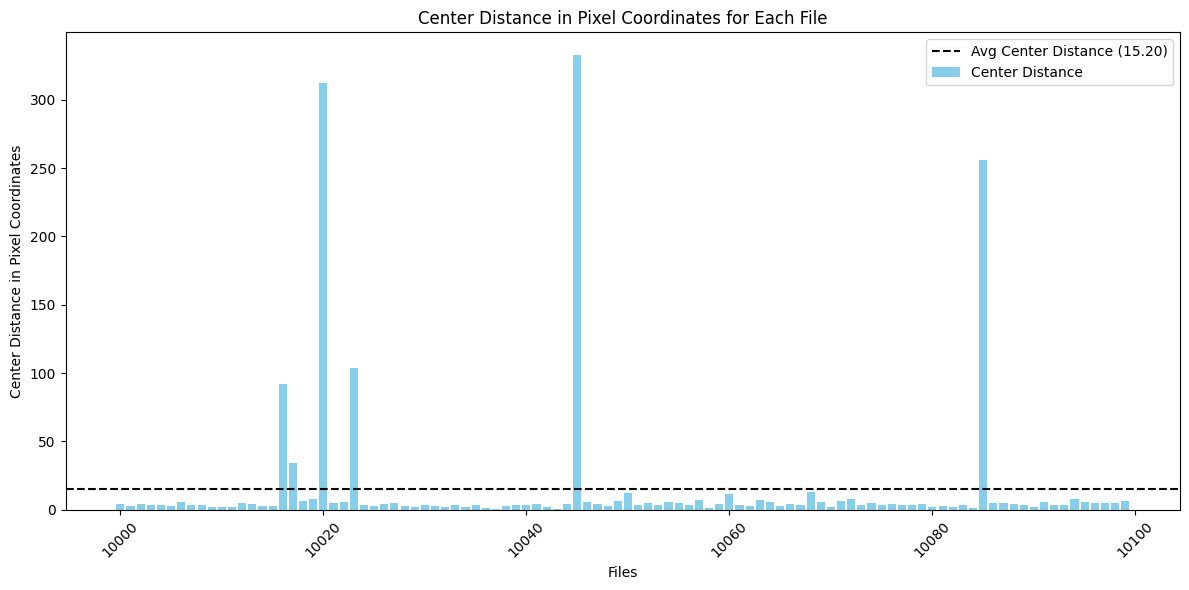

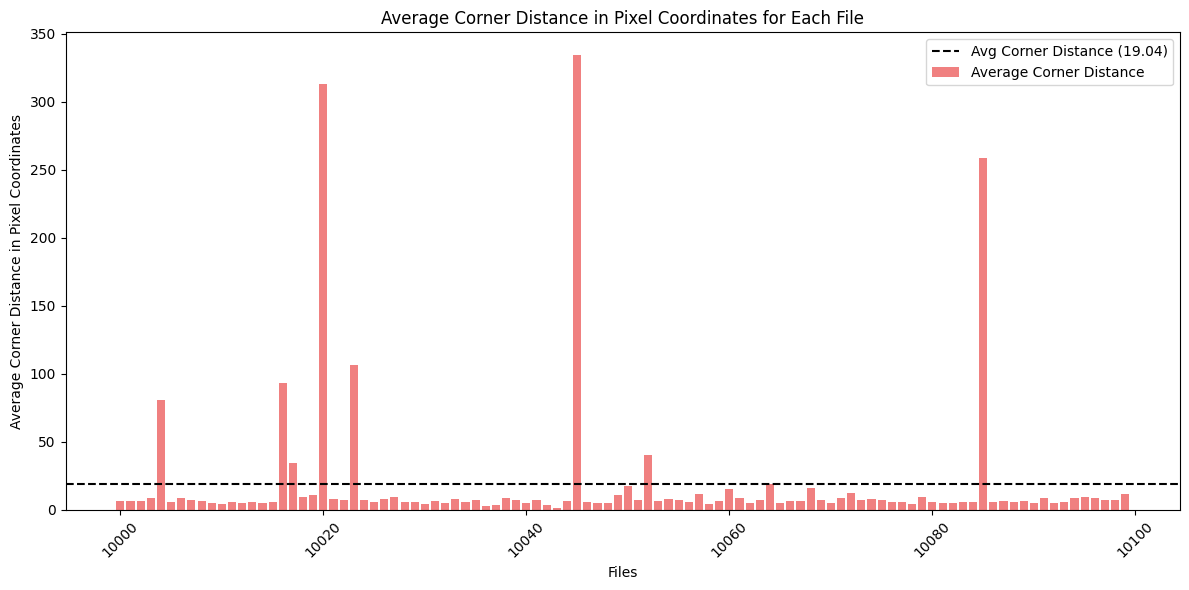

In [18]:
import matplotlib.pyplot as plt
import numpy as np


def generate_bar_plots(results):
    """
    Generate bar plots from the processed results.
    Each bar represents one file with center distance and average corner error.
    Separate plots for each metric are also created.
    """
    # Prepare data
    file_names = []
    center_distances = []
    avg_corner_errors = []

    for file_result in results:
        file_names.append(file_result["file"])
        total_center_distance = 0
        total_avg_corner_error = 0
        count = len(file_result["objects"])
        
        # Sum distances across objects
        for obj in file_result["objects"]:
            total_center_distance += obj["center_distance_non_normalized"]
            total_avg_corner_error += obj["avg_corner_error_non_normalized"]

        # Average values per file
        center_distances.append(total_center_distance / count if count > 0 else 0)
        avg_corner_errors.append(total_avg_corner_error / count if count > 0 else 0)

    # Calculate averages for lines
    avg_center = np.mean(center_distances)
    avg_corner = np.mean(avg_corner_errors)
    
    x = np.arange(len(file_names))

    # Individual Plot: Center Distance with Average Line
    plt.figure(figsize=(12, 6))
    plt.bar(x + starting_index, center_distances, color="skyblue", label="Center Distance")
    plt.axhline(avg_center, color="black", linestyle="--", label=f"Avarage ({avg_center:.2f})")
    plt.xlabel("Files")
    plt.ylabel("Center Distance in Pixel Coordinates")
    plt.title("Center Distance in Pixel Coordinates for Each File")
    plt.legend(loc="upper right")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{save_dir}\\yolo_{dataset}_center_distance.png", dpi=300)
    plt.show()

    # Individual Plot: Average Corner Distance with Average Line
    plt.figure(figsize=(12, 6))
    plt.bar(x + starting_index, avg_corner_errors, color="lightcoral", label="Average Corner Distance")
    plt.axhline(avg_corner, color="black", linestyle="--", label=f"Avarage ({avg_corner:.2f})")
    plt.xlabel("Files")
    plt.ylabel("Average Corner Distance in Pixel Coordinates")
    plt.title("Average Corner Distance in Pixel Coordinates for Each File")
    plt.legend(loc="upper right")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{save_dir}\\yolo_{dataset}_corner_distance.png", dpi=300)
    plt.show()

# Generate the plots
generate_bar_plots(results)


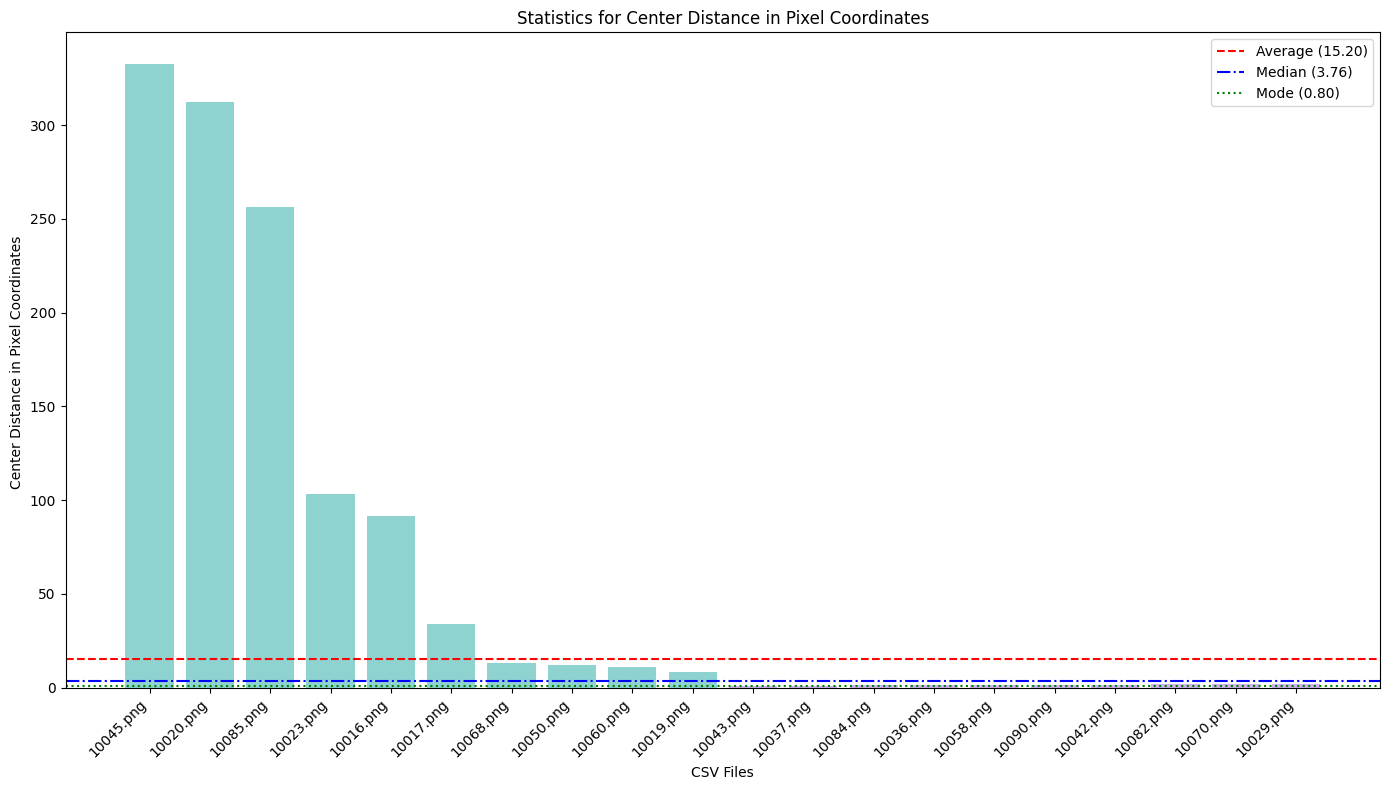

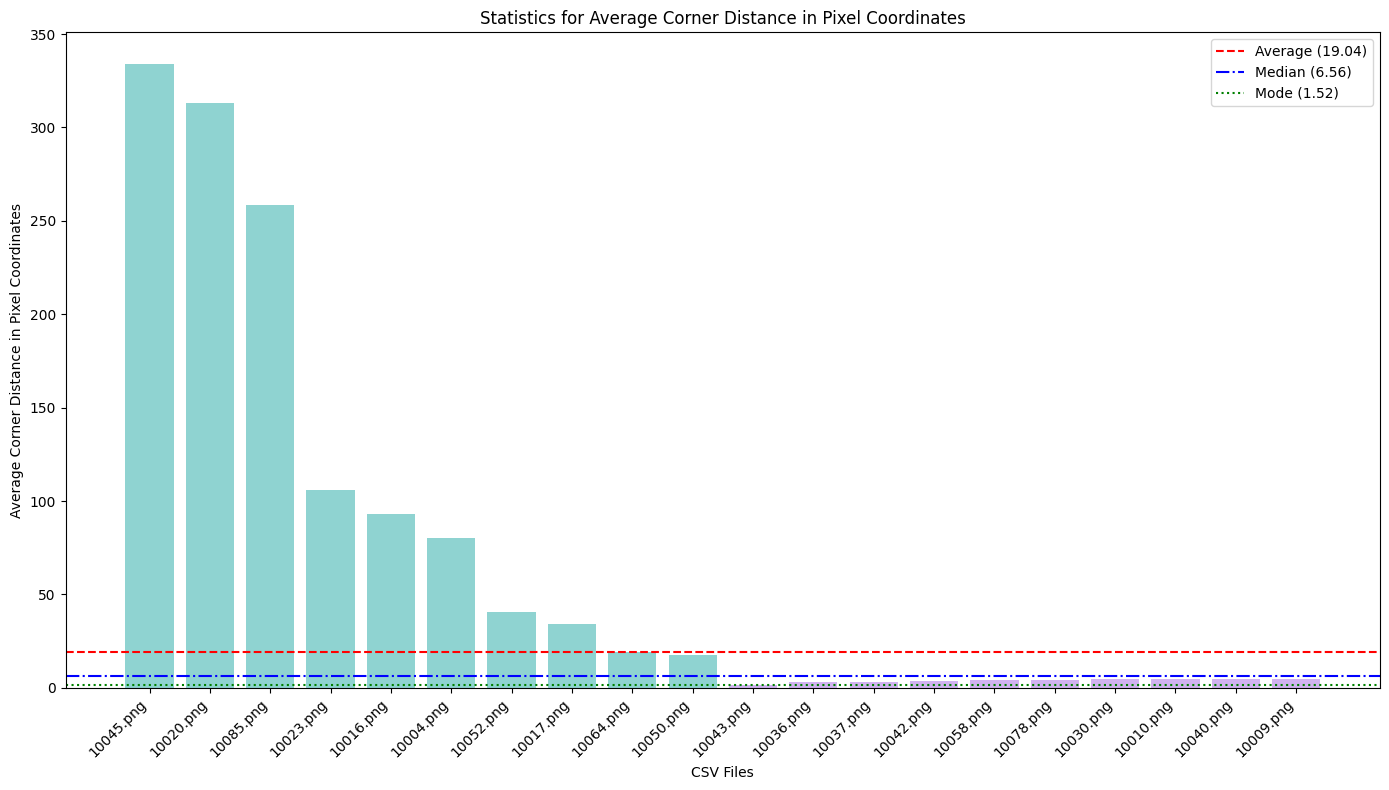

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert results to a DataFrame for analysis
def process_data(results, metric):
    data = []
    for file_result in results:
        file_name = file_result["file"]
        avg_metric_value = np.mean([
            obj.get(metric, 0) for obj in file_result["objects"]
        ]) if file_result["objects"] else 0
        data.append({"File": file_name, metric: avg_metric_value})
    return pd.DataFrame(data)

# Function to identify outliers, average, median, and mode
def identify_statistics_euc(df, metric):
    top_10_highest = df.nlargest(10, metric)
    top_10_lowest = df.nsmallest(10, metric)
    median_value = df[metric].median()
    avg_value = df[metric].mean()
    mode_value = df[metric].mode().iloc[0] if not df[metric].mode().empty else None
    return top_10_highest, top_10_lowest, avg_value, median_value, mode_value

# Visualization function for center_distance_non_normalized
def visualize_center_distance_non_normalized(results):
    metric = "center_distance_non_normalized"
    df = process_data(results, metric)
    top_10_high, top_10_low, avg_value, median_value, mode_value = identify_statistics_euc(df, metric)

    plt.figure(figsize=(14, 8))
    combined = pd.concat([top_10_high, top_10_low])
    labels = combined["File"]
    values = combined[metric]
    colors = ['#8fd3d1'] * len(top_10_high) + ['#d1b3f0'] * len(top_10_low)

    plt.bar(labels, values, color=colors)
    plt.axhline(avg_value, color='red', linestyle='--', label=f'Average ({avg_value:.2f})')
    plt.axhline(median_value, color='blue', linestyle='-.', label=f'Median ({median_value:.2f})')
    if mode_value is not None:
        plt.axhline(mode_value, color='green', linestyle=':', label=f'Mode ({mode_value:.2f})')

    plt.xlabel("CSV Files")
    plt.ylabel("Center Distance in Pixel Coordinates ")
    plt.title("Statistics for Center Distance in Pixel Coordinates")
    plt.xticks(rotation=45, ha="right")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f"{save_dir}\\yolo_{dataset}_{metric.lower()}_statistics.png", dpi=300)
    plt.show()

# Visualization function for avg_corner_error_non_normalized
def visualize_avg_corner_error_non_normalized(results):
    metric = "avg_corner_error_non_normalized"
    df = process_data(results, metric)
    top_10_high, top_10_low, avg_value, median_value, mode_value = identify_statistics_euc(df, metric)

    plt.figure(figsize=(14, 8))
    combined = pd.concat([top_10_high, top_10_low])
    labels = combined["File"]
    values = combined[metric]
    colors = ['#8fd3d1'] * len(top_10_high) + ['#d1b3f0'] * len(top_10_low)

    plt.bar(labels, values, color=colors)
    plt.axhline(avg_value, color='red', linestyle='--', label=f'Average ({avg_value:.2f})')
    plt.axhline(median_value, color='blue', linestyle='-.', label=f'Median ({median_value:.2f})')
    if mode_value is not None:
        plt.axhline(mode_value, color='green', linestyle=':', label=f'Mode ({mode_value:.2f})')

    plt.xlabel("CSV Files")
    plt.ylabel("Average Corner Distance in Pixel Coordinates")
    plt.title("Statistics for Average Corner Distance in Pixel Coordinates")
    plt.xticks(rotation=45, ha="right")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f"{save_dir}\\yolo_{dataset}_{metric.lower()}_statistics.png", dpi=300)
    plt.show()

# Generate individual plots
visualize_center_distance_non_normalized(results)
visualize_avg_corner_error_non_normalized(results)


# False Detections and Not Detected

In [20]:
def calculate_fp_and_nd(predictions, ground_truth):
    """
    Calculate False Positives (FP) and Not Detected (ND).
    """
    # If either DataFrame is empty, handle gracefully
    if predictions.empty and ground_truth.empty:
        return 0, 0
    elif predictions.empty:
        return 0, len(ground_truth)
    elif ground_truth.empty:
        return len(predictions), 0

    # Ensure the required column exists
    if 0 not in predictions.columns or 0 not in ground_truth.columns:
        print("Error: Column 0 (Object ID) is missing in one of the DataFrames.")
        return 0, 0

    # Group ground truth and predictions by object ID
    gt_groups = ground_truth.groupby(0)
    pred_groups = predictions.groupby(0)

    # Unique IDs in predictions and ground truth
    gt_ids = set(gt_groups.groups.keys())
    pred_ids = set(pred_groups.groups.keys())

    # Initialize counters for FP and ND
    false_detections = 0
    not_detected = 0

    # IDs only in ground truth (ND)
    unique_gt_ids = gt_ids - pred_ids
    not_detected += sum(len(gt_groups.get_group(id)) for id in unique_gt_ids)

    # IDs only in predictions (FP)
    unique_pred_ids = pred_ids - gt_ids
    false_detections += sum(len(pred_groups.get_group(id)) for id in unique_pred_ids)

    # IDs present in both
    common_ids = gt_ids & pred_ids
    for obj_id in common_ids:
        gt_count = len(gt_groups.get_group(obj_id))
        pred_count = len(pred_groups.get_group(obj_id))

        # Count mismatched instances
        if pred_count > gt_count:
            false_detections += pred_count - gt_count
        elif gt_count > pred_count:
            not_detected += gt_count - pred_count

    return false_detections, not_detected


def process_file_fp_nd(model, image_path, gt_file):
    """
    Process a single file and calculate False Positives (FP) and Not Detected (ND).
    """
    # Perform YOLO inference
    results = model(image_path)[0]

    # Get image dimensions
    img = Image.open(image_path)
    width, height = img.size

    # Prepare prediction data
    predictions = []
    for result in results:
        # Object ID
        obj_id = int(result.boxes.cls[0])  # Class ID

        # Bounding box center and size
        box = result.boxes.xyxy[0].tolist()
        center_x = (box[0] + box[2]) / 2 / width
        center_y = (box[1] + box[3]) / 2 / height
        size_x = (box[2] - box[0]) / width
        size_y = (box[3] - box[1]) / height

        # Keypoints (if available)
        keypoints = []
        if result.keypoints is not None:
            keypoints = result.keypoints.xy[0].tolist()
            keypoints = [(kp[0] / width, kp[1] / height) for kp in keypoints[:8]]

        # Prepare prediction row
        row = [obj_id, center_x, center_y, size_x, size_y]
        row.extend(sum(keypoints, ()))
        predictions.append(row)

    # Convert predictions to DataFrame
    predictions_df = pd.DataFrame(predictions)

    # Load ground truth
    ground_truth = pd.read_csv(gt_file, header=None)

    # Handle empty DataFrames gracefully
    if predictions_df.empty or ground_truth.empty:
        print(f"Skipping file {os.path.basename(image_path)} due to empty DataFrames.")
        return {
            "file": os.path.basename(image_path),
            "false_detections": len(predictions_df),
            "not_detected": len(ground_truth)
        }

    # Calculate FP and ND
    false_detections, not_detected = calculate_fp_and_nd(predictions_df, ground_truth)

    return {
        "file": os.path.basename(image_path),
        "false_detections": false_detections,
        "not_detected": not_detected,
    }


def process_all_files_fp_nd(model_path, image_dir, ground_truth_dir, max_files):
    """
    Process all files to calculate False Positives (FP) and Not Detected (ND).

    """
    def extract_numeric(file_name):
        # Extract the numeric part of the file name (e.g., "123" from "123.png")
        return int(os.path.splitext(file_name)[0])

    # Load YOLO model
    model = YOLO(model_path)
    results = []

    # List and sort files numerically
    image_files = sorted(
        [file_name for file_name in os.listdir(image_dir) if file_name.endswith(".png")],
        key=extract_numeric
    )

    # Limit the number of files to process if max_files is set
    if max_files is not None:
        image_files = image_files[:max_files]

    for file_name in image_files:
        # Image file name without extension
        base_name = os.path.splitext(file_name)[0]

        # Paths
        image_path = os.path.join(image_dir, file_name)
        gt_file = os.path.join(ground_truth_dir, f"{base_name}.csv")

        if not os.path.exists(gt_file):
            print(f"Missing ground truth for {base_name}, skipping...")
            continue

        # Process a single file
        try:
            file_results = process_file_fp_nd(model, image_path, gt_file)
            results.append({
                "file": file_results["file"],
                "false_detections": file_results["false_detections"],
                "not_detected": file_results["not_detected"]
            })
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

    return results



# Calculate FP and ND
results = process_all_files_fp_nd(model_path, image_dir, ground_truth_dir, max_files)

print("Results:")
for result in results:
    print(result)



image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10000.png: 384x640 2 Vertexs, 1 Common Chair, 1 Door, 1 Office Chair, 1 Window, 94.7ms
Speed: 2.0ms preprocess, 94.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10001.png: 384x640 6 Vertexs, 1 Office Chair, 2 Windows, 90.8ms
Speed: 3.0ms preprocess, 90.8ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10002.png: 384x640 5 Vertexs, 1 Common Chair, 1 Door, 63.8ms
Speed: 1.0ms preprocess, 63.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10003.png: 384x640 4 Vertexs, 1 Common Chair, 1 Office Chair, 2 Windows, 57.9ms
Speed: 2.0ms preprocess, 57.9ms inference, 1.0ms postprocess per imag

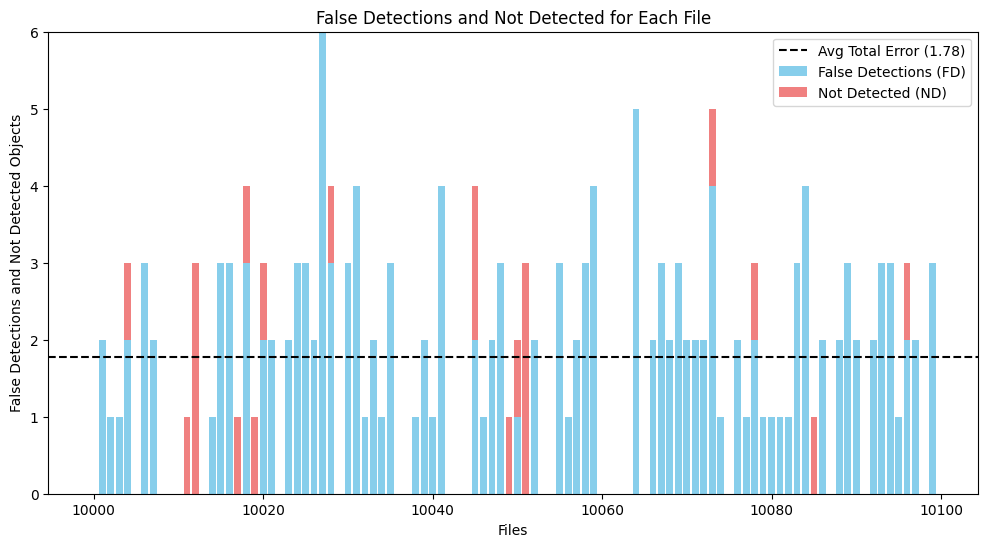

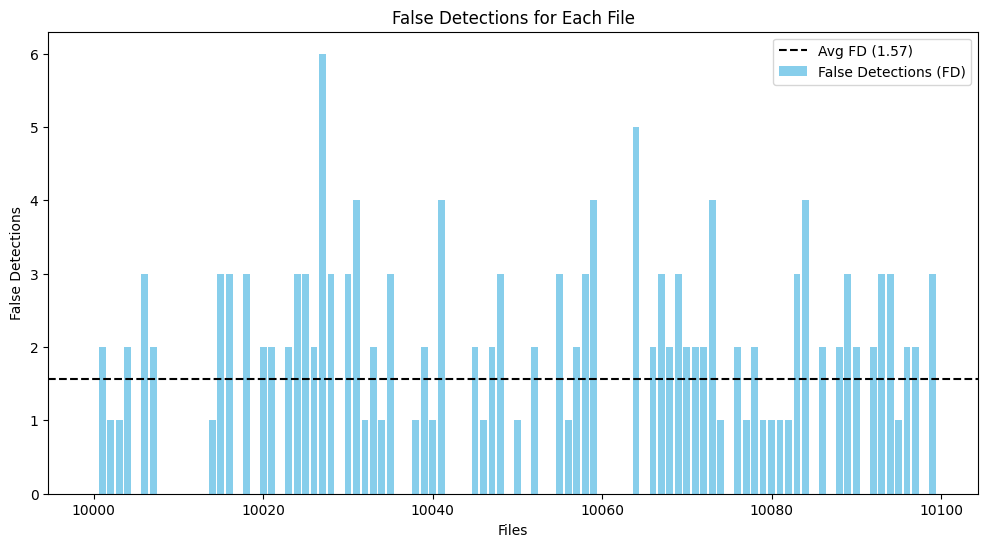

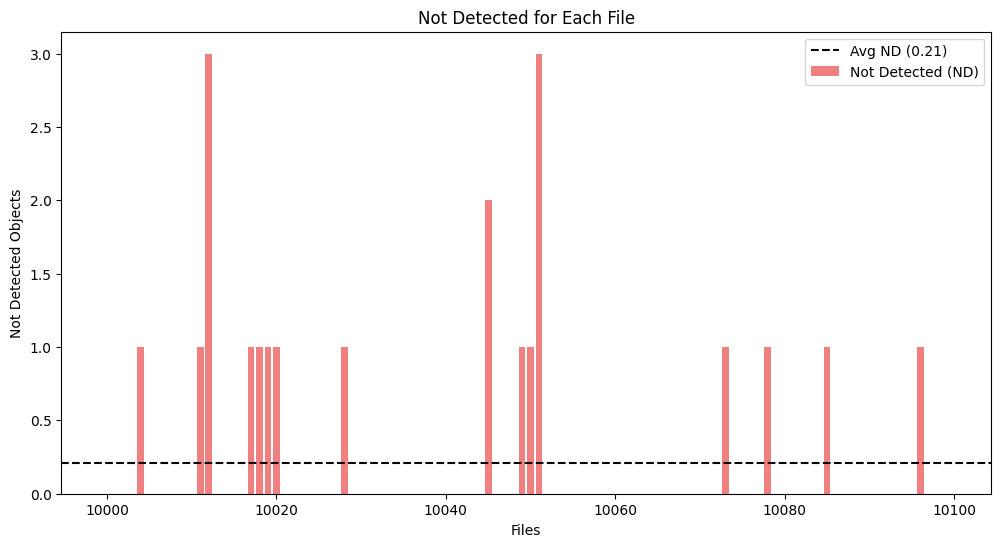

In [24]:
import matplotlib.pyplot as plt
import numpy as np


# Generate bar plots with updated results
def generate_fp_nd_bar_plots(results):
    """
    Generate bar plots for False Positives (FP) and Not Detected (ND).
    Each bar represents one file with FP and ND stacked.
    Also generates individual plots for FP and ND with average lines.
    """
    # Prepare data
    file_names = [result["file"] for result in results]
    false_detections = [result["false_detections"] for result in results]
    not_detected = [result["not_detected"] for result in results]

    # Calculate averages for lines
    avg_fp = np.mean(false_detections)
    avg_nd = np.mean(not_detected)
    
    x = np.arange(len(file_names))

    # Stacked Bar Plot: FP and ND
    plt.figure(figsize=(12, 6))
    plt.bar(x + starting_index, false_detections, label="False Detections (FD)", color="skyblue")
    plt.bar(x + starting_index, not_detected, bottom=false_detections, label="Not Detected (ND)", color="lightcoral")
    plt.axhline(avg_fp + avg_nd, color="black", linestyle="--", label=f"Avarage ({avg_fp + avg_nd:.2f})")
    plt.xlabel("Files")
    plt.ylabel("False Detections and Not Detected Objects")
    plt.title("False Detections and Not Detected for Each File")
    plt.legend(loc="upper right")
    plt.savefig(f"{save_dir}\\yolo_{dataset}_false_detections_and_not_detected.png", dpi=300)
    plt.show()

    # Individual Plot: False Positives with Average Line
    plt.figure(figsize=(12, 6))
    plt.bar(x + starting_index, false_detections, color="skyblue", label="False Detections (FD)")
    plt.axhline(avg_fp, color="black", linestyle="--", label=f"Avarage ({avg_fp:.2f})")
    plt.xlabel("Files")
    plt.ylabel("False Detections")
    plt.title("False Detections for Each File")
    plt.legend(loc="upper right")
    plt.savefig(f"{save_dir}\\yolo_{dataset}_false_detections.png", dpi=300)
    plt.show()

    # Individual Plot: Not Detected with Average Line
    plt.figure(figsize=(12, 6))
    plt.bar(x + starting_index, not_detected, color="lightcoral", label="Not Detected (ND)")
    plt.axhline(avg_nd, color="black", linestyle="--", label=f"Avarage ({avg_nd:.2f})")
    plt.xlabel("Files")
    plt.ylabel("Not Detected Objects")
    plt.title("Not Detected for Each File")
    plt.legend(loc="upper right")
    plt.savefig(f"{save_dir}\\yolo_{dataset}_not_detected.png", dpi=300)
    plt.show()


# Generate the plots
generate_fp_nd_bar_plots(results)


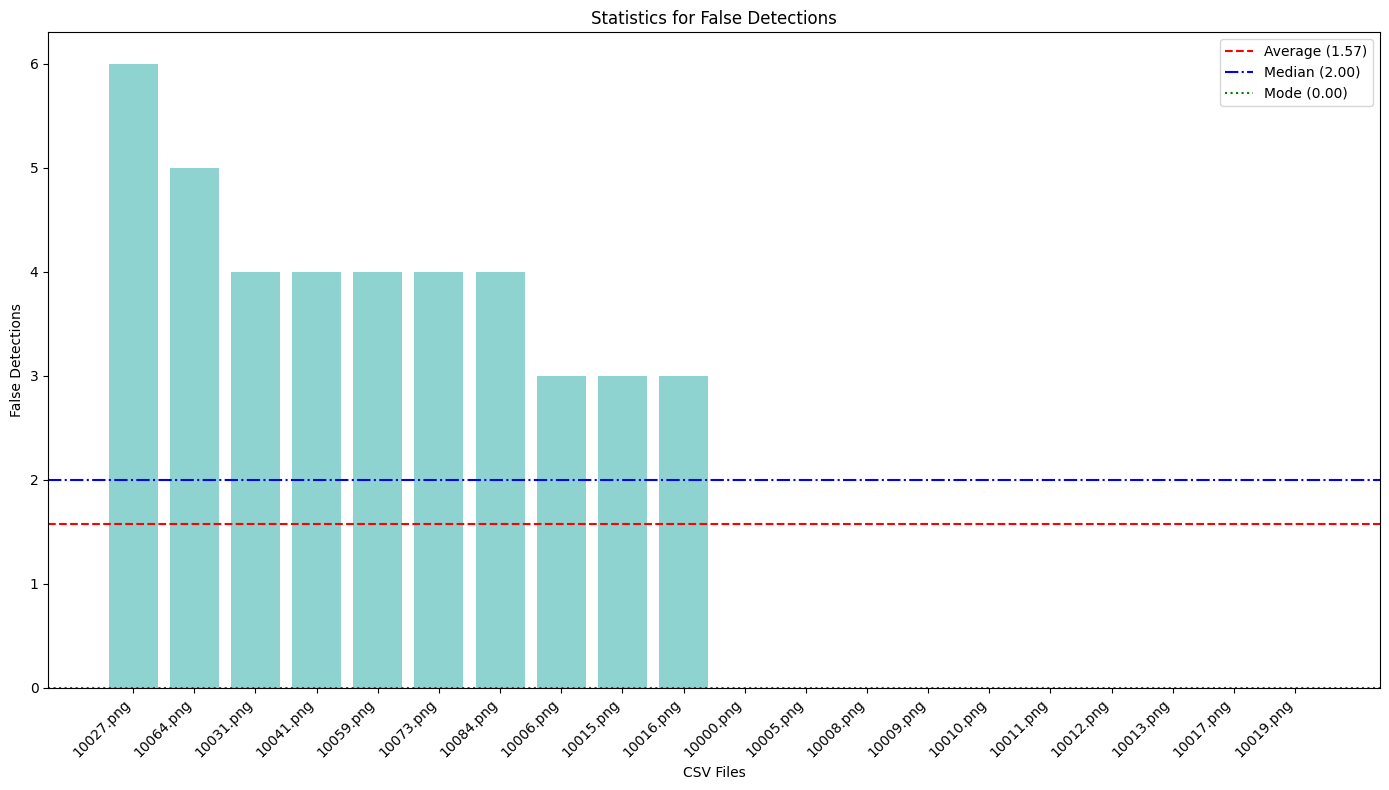

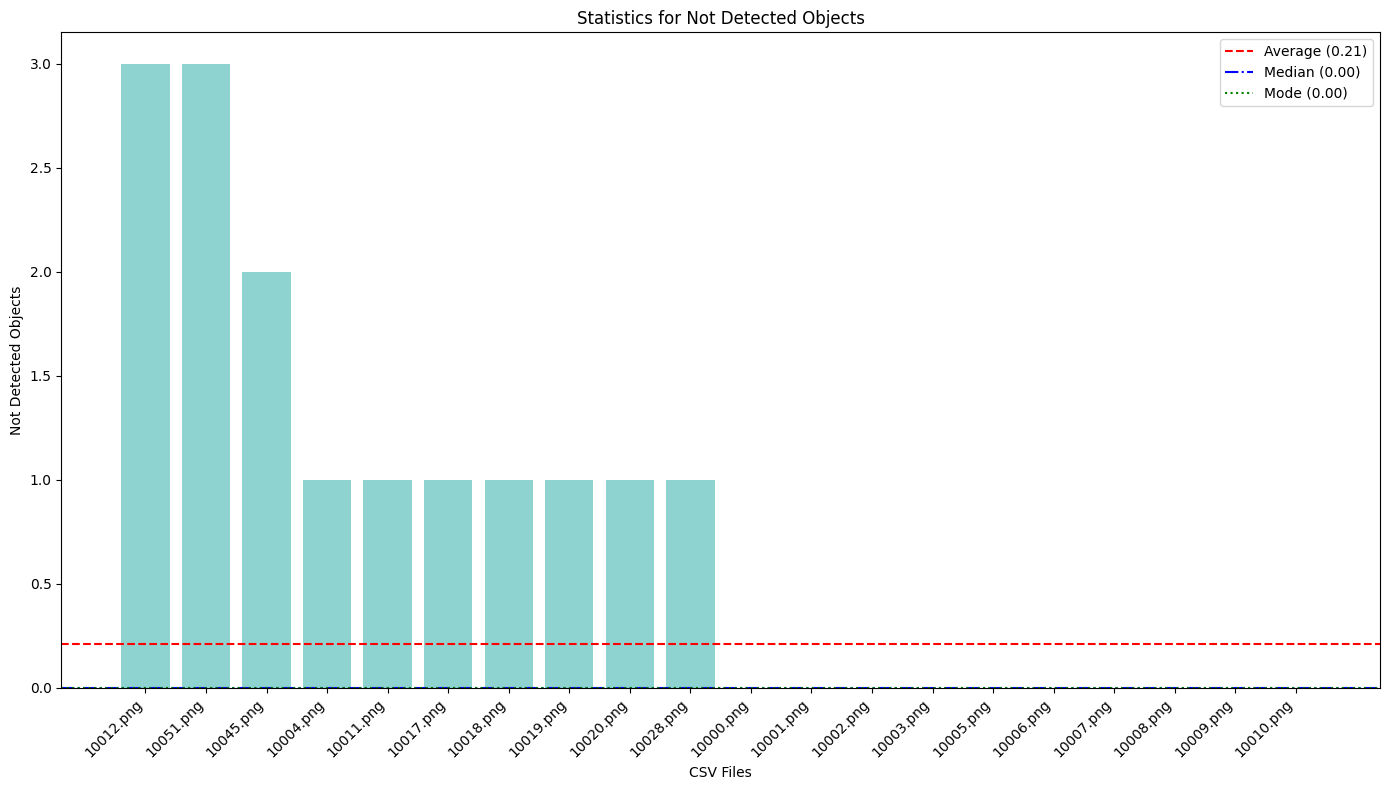

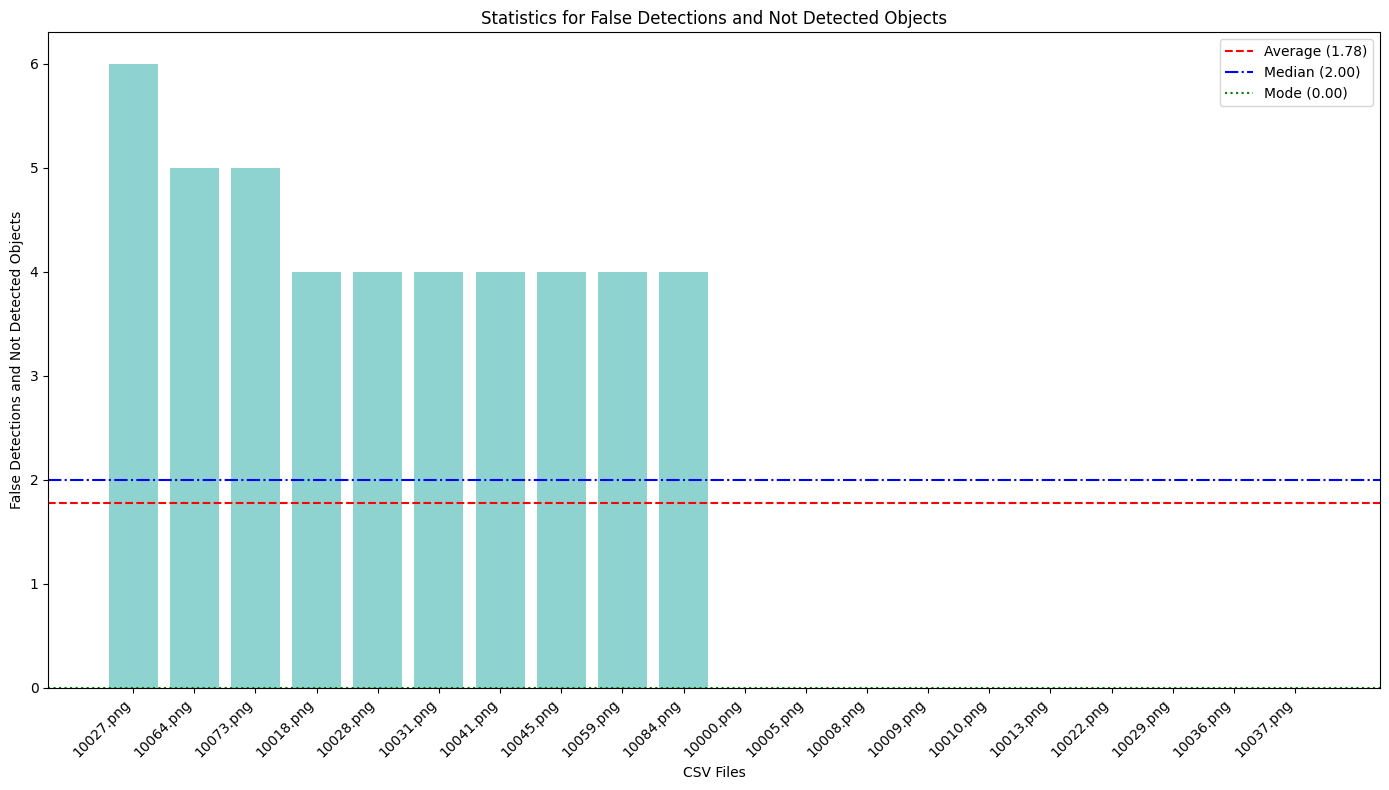

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert FP and ND results to a DataFrame for analysis
def process_fp_nd_results(results):
    """
    Process results to calculate false detections, not detected, and their combined sum.
    """
    data = []
    for result in results:
        file_name = result["file"]
        false_detections = result.get("false_detections", 0)
        not_detected = result.get("not_detected", 0)
        combined_metric = false_detections + not_detected
        data.append({
            "File": file_name,
            "false_detections": false_detections,
            "not_detected": not_detected,
            "combined_metric": combined_metric
        })
    return pd.DataFrame(data)

# Identify statistics for a given metric
def identify_statistics_fd_nd(df, metric):
    """
    Identify statistical measures for the specified metric.
    """
    top_10_highest = df.nlargest(10, metric)
    top_10_lowest = df.nsmallest(10, metric)
    median_value = df[metric].median()
    avg_value = df[metric].mean()
    mode_value = df[metric].mode().iloc[0] if not df[metric].mode().empty else None
    return top_10_highest, top_10_lowest, avg_value, median_value, mode_value

# Visualize false detections
def visualize_false_detections(df, save_dir, dataset):
    """
    Visualize statistics for false detections.
    """
    metric = "false_detections"
    top_10_high, top_10_low, avg_value, median_value, mode_value = identify_statistics_fd_nd(df, metric)

    plt.figure(figsize=(14, 8))
    combined = pd.concat([top_10_high, top_10_low])
    labels = combined["File"]
    values = combined[metric]
    colors = ['#8fd3d1'] * len(top_10_high) + ['#d1b3f0'] * len(top_10_low)

    plt.bar(labels, values, color=colors)
    plt.axhline(avg_value, color='red', linestyle='--', label=f'Average ({avg_value:.2f})')
    plt.axhline(median_value, color='blue', linestyle='-.', label=f'Median ({median_value:.2f})')
    if mode_value is not None:
        plt.axhline(mode_value, color='green', linestyle=':', label=f'Mode ({mode_value:.2f})')

    plt.xlabel("CSV Files")
    plt.ylabel("False Detections")
    plt.title("Statistics for False Detections")
    plt.xticks(rotation=45, ha="right")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f"{save_dir}/yolo_{dataset}_{metric}.png", dpi=300)
    plt.show()

# Visualize not detected
def visualize_not_detected(df, save_dir, dataset):
    """
    Visualize statistics for not detected.
    """
    metric = "not_detected"
    top_10_high, top_10_low, avg_value, median_value, mode_value = identify_statistics_fd_nd(df, metric)

    plt.figure(figsize=(14, 8))
    combined = pd.concat([top_10_high, top_10_low])
    labels = combined["File"]
    values = combined[metric]
    colors = ['#8fd3d1'] * len(top_10_high) + ['#d1b3f0'] * len(top_10_low)

    plt.bar(labels, values, color=colors)
    plt.axhline(avg_value, color='red', linestyle='--', label=f'Average ({avg_value:.2f})')
    plt.axhline(median_value, color='blue', linestyle='-.', label=f'Median ({median_value:.2f})')
    if mode_value is not None:
        plt.axhline(mode_value, color='green', linestyle=':', label=f'Mode ({mode_value:.2f})')

    plt.xlabel("CSV Files")
    plt.ylabel("Not Detected Objects")
    plt.title("Statistics for Not Detected Objects")
    plt.xticks(rotation=45, ha="right")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f"{save_dir}/yolo_{dataset}_{metric}.png", dpi=300)
    plt.show()

# Visualize combined metric
def visualize_combined_metric(df, save_dir, dataset):
    """
    Visualize statistics for the combined metric (false detections + not detected).
    """
    metric = "combined_metric"
    top_10_high, top_10_low, avg_value, median_value, mode_value = identify_statistics_fd_nd(df, metric)

    plt.figure(figsize=(14, 8))
    combined = pd.concat([top_10_high, top_10_low])
    labels = combined["File"]
    values = combined[metric]
    colors = ['#8fd3d1'] * len(top_10_high) + ['#d1b3f0'] * len(top_10_low)

    plt.bar(labels, values, color=colors)
    plt.axhline(avg_value, color='red', linestyle='--', label=f'Average ({avg_value:.2f})')
    plt.axhline(median_value, color='blue', linestyle='-.', label=f'Median ({median_value:.2f})')
    if mode_value is not None:
        plt.axhline(mode_value, color='green', linestyle=':', label=f'Mode ({mode_value:.2f})')

    plt.xlabel("CSV Files")
    plt.ylabel("False Detections and Not Detected Objects")
    plt.title("Statistics for False Detections and Not Detected Objects")
    plt.xticks(rotation=45, ha="right")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f"{save_dir}/yolo_{dataset}_{metric}.png", dpi=300)
    plt.show()

# Process results and generate plots
df = process_fp_nd_results(results)

# Generate separate plots
visualize_false_detections(df, save_dir, dataset)
visualize_not_detected(df, save_dir, dataset)
visualize_combined_metric(df, save_dir, dataset)


# Intersection Area

In [26]:
import os
import pandas as pd
from ultralytics import YOLO
from PIL import Image


def compute_intersection_area_ratio(gt_row, pred_row, width, height):
    """
    Computes the intersection area ratio of two bounding boxes (ground truth and prediction).
    """
    # Ground truth bounding box edges
    gt_center_x = gt_row[1] * width
    gt_center_y = gt_row[2] * height
    gt_bbox_width = gt_row[3] * width
    gt_bbox_height = gt_row[4] * height

    gt_x1 = gt_center_x - (gt_bbox_width / 2)
    gt_y1 = gt_center_y - (gt_bbox_height / 2)
    gt_x2 = gt_center_x + (gt_bbox_width / 2)
    gt_y2 = gt_center_y + (gt_bbox_height / 2)

    # Prediction bounding box edges
    pred_center_x = pred_row[1] * width
    pred_center_y = pred_row[2] * height
    pred_bbox_width = pred_row[3] * width
    pred_bbox_height = pred_row[4] * height

    pred_x1 = pred_center_x - (pred_bbox_width / 2)
    pred_y1 = pred_center_y - (pred_bbox_height / 2)
    pred_x2 = pred_center_x + (pred_bbox_width / 2)
    pred_y2 = pred_center_y + (pred_bbox_height / 2)

    # Calculate the intersection box
    inter_x1 = max(gt_x1, pred_x1)
    inter_y1 = max(gt_y1, pred_y1)
    inter_x2 = min(gt_x2, pred_x2)
    inter_y2 = min(gt_y2, pred_y2)

    # Calculate intersection area
    inter_width = max(0, inter_x2 - inter_x1)
    inter_height = max(0, inter_y2 - inter_y1)
    intersection_area = inter_width * inter_height

    # Calculate ground truth area
    gt_area = max(0, (gt_x2 - gt_x1) * (gt_y2 - gt_y1))

    # Avoid division by zero
    if gt_area == 0:
        return 0

    # Return the intersection area ratio
    return intersection_area / gt_area



def calculate_intersection_ratios(predictions, ground_truth, width, height):
    """
    Calculate the intersection area ratios for matched predictions and ground truths.
    """
    results = []

    if predictions.empty or ground_truth.empty:
        print("One of the DataFrames is empty, skipping...")
        return results

    try:
        # Group ground truth and predictions by object ID
        gt_groups = ground_truth.groupby(0)
        pred_groups = predictions.groupby(0)

        # Get the intersection of IDs present in both predictions and ground truth
        common_ids = set(gt_groups.groups.keys()) & set(pred_groups.groups.keys())

        for obj_id in common_ids:
            gt_rows = ground_truth.loc[gt_groups.groups[obj_id]].copy()
            pred_rows = predictions.loc[pred_groups.groups[obj_id]].copy()

            # Match predictions and ground truth for this object ID
            while not gt_rows.empty and not pred_rows.empty:
                max_ratio = None
                max_gt_index = None
                max_pred_index = None

                # Find the prediction-ground truth pair with the highest intersection ratio
                for gt_index, gt_row in gt_rows.iterrows():
                    for pred_index, pred_row in pred_rows.iterrows():
                        ratio = compute_intersection_area_ratio(gt_row, pred_row, width, height)
                        if max_ratio is None or ratio > max_ratio:
                            max_ratio = ratio
                            max_gt_index = gt_index
                            max_pred_index = pred_index

                # Save the intersection ratio result
                results.append({
                    "id": obj_id,
                    "intersection_ratio": max_ratio
                })

                # Remove matched rows
                gt_rows.drop(index=max_gt_index, inplace=True)
                pred_rows.drop(index=max_pred_index, inplace=True)
    except Exception as e:
        print(f"Error calculating intersection ratios: {e}")
    return results


def process_file_intersection(model, image_path, gt_file):
    """
    Process a single image and calculate intersection area ratios.
    """
    try:
        # Perform YOLO inference
        results = model(image_path)[0]

        # Get image dimensions
        img = Image.open(image_path)
        width, height = img.size

        # Prepare prediction data
        predictions = []
        for result in results:
            # Object ID
            obj_id = int(result.boxes.cls[0])  # Class ID

            # Bounding box center and size
            box = result.boxes.xyxy[0].tolist()
            center_x = (box[0] + box[2]) / 2 / width
            center_y = (box[1] + box[3]) / 2 / height
            size_x = (box[2] - box[0]) / width
            size_y = (box[3] - box[1]) / height

            # Prepare prediction row
            row = [obj_id, center_x, center_y, size_x, size_y]
            predictions.append(row)

        # Convert predictions to DataFrame
        predictions_df = pd.DataFrame(predictions)

        # Load ground truth
        ground_truth = pd.read_csv(gt_file, header=None)

        # Ensure DataFrames are not empty
        if predictions_df.empty or ground_truth.empty:
            print(f"Empty DataFrame encountered for {os.path.basename(image_path)}, skipping...")
            return {"file": os.path.basename(image_path), "objects": []}

        # Calculate intersection ratios
        results = calculate_intersection_ratios(predictions_df, ground_truth, width, height)

        # Prepare results for the file
        file_results = {"file": os.path.basename(image_path), "objects": results}
        return file_results
    except Exception as e:
        print(f"Error processing file {os.path.basename(image_path)}: {e}")
        return {"file": os.path.basename(image_path), "objects": []}


def process_all_files_intersection(model_path, image_dir, ground_truth_dir, max_files):
    """
    Process all images and calculate intersection area ratios.
    """
    def extract_numeric(file_name):
        # Extract the numeric part of the file name (e.g., "123" from "123.png")
        return int(os.path.splitext(file_name)[0])

    # Load YOLO model
    model = YOLO(model_path)
    all_results = []

    # List and sort files numerically
    image_files = sorted(
        [file_name for file_name in os.listdir(image_dir) if file_name.endswith(".png")],
        key=extract_numeric
    )

    # Limit the number of files to process if max_files is set
    if max_files is not None:
        image_files = image_files[:max_files]

    for file_name in image_files:
        image_path = os.path.join(image_dir, file_name)
        gt_file = os.path.join(ground_truth_dir, f"{os.path.splitext(file_name)[0]}.csv")

        if not os.path.exists(gt_file):
            print(f"Missing ground truth for {file_name}, skipping...")
            continue

        # Process a single file and collect results
        try:
            file_results = process_file_intersection(model, image_path, gt_file)
            all_results.append(file_results)
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

    return all_results

# Process files and collect results
results = process_all_files_intersection(model_path, image_dir, ground_truth_dir, max_files)

print("Intersection Area Ratios:")
for file_result in results:
    print(file_result)



image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10000.png: 384x640 2 Vertexs, 1 Common Chair, 1 Door, 1 Office Chair, 1 Window, 64.8ms
Speed: 3.0ms preprocess, 64.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10001.png: 384x640 6 Vertexs, 1 Office Chair, 2 Windows, 62.3ms
Speed: 2.0ms preprocess, 62.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10002.png: 384x640 5 Vertexs, 1 Common Chair, 1 Door, 58.4ms
Speed: 1.0ms preprocess, 58.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10003.png: 384x640 4 Vertexs, 1 Common Chair, 1 Office Chair, 2 Windows, 55.4ms
Speed: 2.0ms preprocess, 55.4ms inference, 1.0ms postprocess per imag

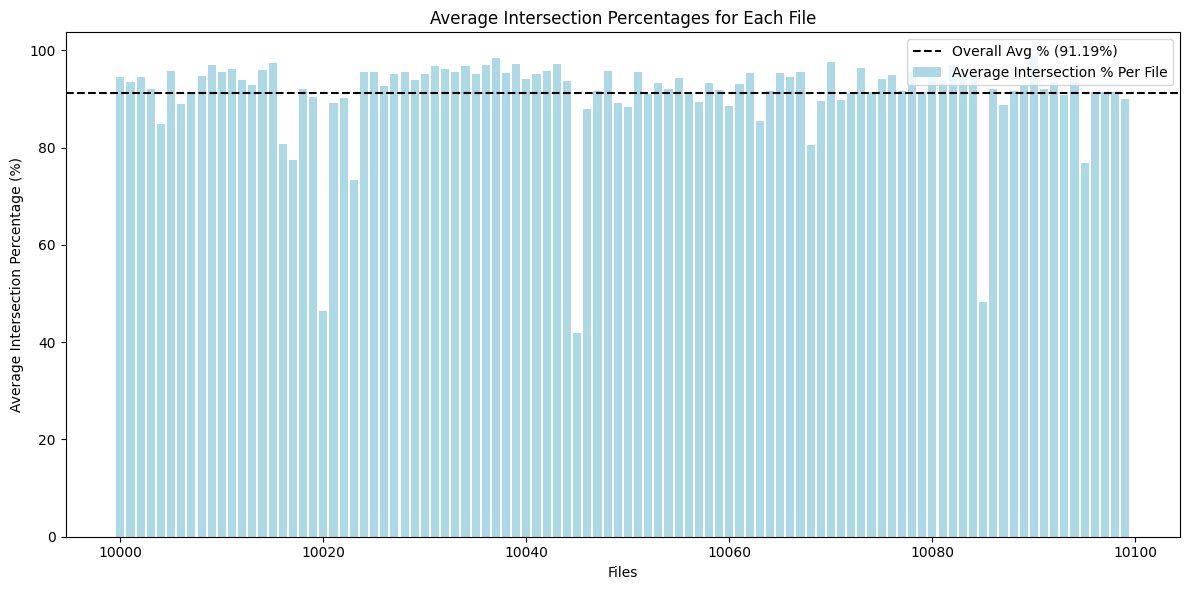

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def generate_average_intersection_plot(results):
    """
    Generate a bar plot showing the average intersection percentage for each file
    and a line for the overall average percentage.
    """
    # Prepare data
    file_names = [result.get("file", "Unknown") for result in results]
    avg_ratios_per_file = [
        100 * np.mean([obj.get("intersection_ratio", 0) for obj in result.get("objects", [])]) if result.get("objects") else 0
        for result in results
    ]
    overall_avg_ratio = np.mean([ratio for ratio in avg_ratios_per_file if ratio > 0])

    x = np.arange(len(file_names))

    # Bar Plot: Average Ratios Per File
    plt.figure(figsize=(12, 6))
    plt.bar(x + starting_index, avg_ratios_per_file, color="lightblue", label="Average Intersection % Per File")
    plt.axhline(overall_avg_ratio, color="black", linestyle="--", label=f"Avarage ({overall_avg_ratio:.2f}%)")
    plt.xlabel("Files")
    plt.ylabel("Average Intersection Percentage (%)")
    plt.title("Average Intersection Percentages for Each File")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.savefig(f"{save_dir}\\yolo_{dataset}_average_intersection_percentage.png", dpi=300)
    plt.show()

# Generate the plot
generate_average_intersection_plot(results)


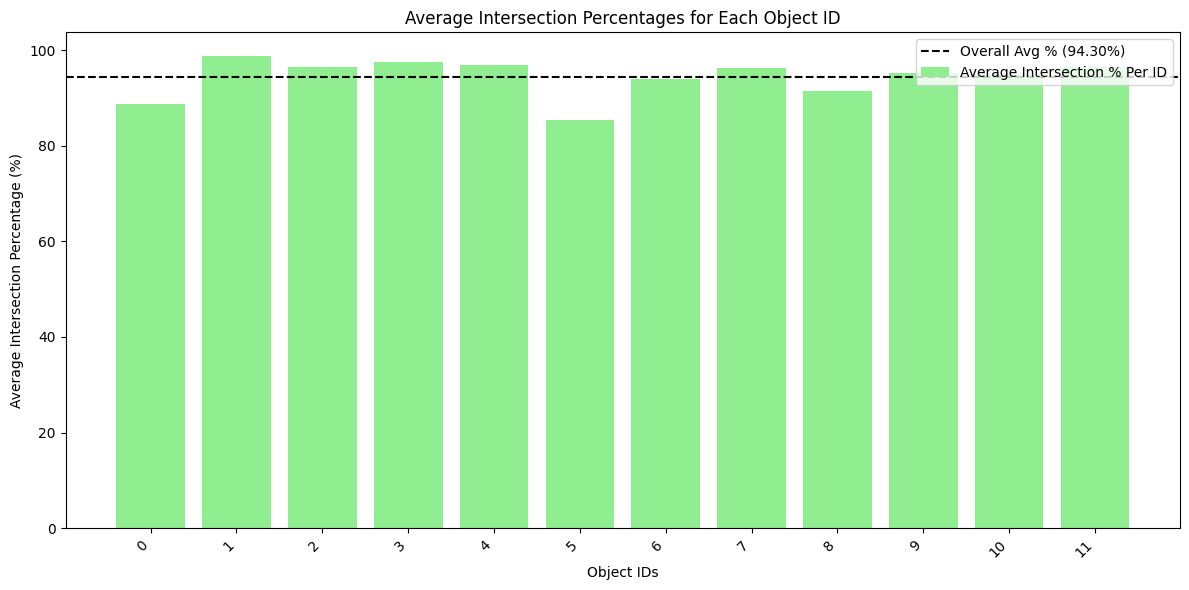

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict


def generate_intersection_plot_per_id(results):
    """
    Generate bar plots showing the average intersection percentage for each object ID across files.
    """
    # Collect data per ID
    id_data = defaultdict(list)  # {id: [ratios]}
    for result in results:
        for obj in result.get("objects", []):
            obj_id = obj.get("id")
            intersection_ratio = 100 * obj.get("intersection_ratio", 0)  # Convert to percentage
            id_data[obj_id].append(intersection_ratio)

    # Calculate average ratios per ID
    avg_ratios_per_id = {obj_id: np.mean(ratios) for obj_id, ratios in id_data.items() if ratios}

    # Sort IDs for consistent plotting
    sorted_ids = sorted(avg_ratios_per_id.keys())

    # Prepare data for plotting
    avg_ratios = [avg_ratios_per_id[obj_id] for obj_id in sorted_ids]

    x = np.arange(len(sorted_ids))

    # Bar Plot: Average Intersection Ratios Per ID
    plt.figure(figsize=(12, 6))
    plt.bar(x, avg_ratios, color="lightgreen", label="Average Intersection % Per ID")
    overall_avg_ratio = np.mean(avg_ratios)
    plt.axhline(overall_avg_ratio, color="black", linestyle="--", label=f"Avarage ({overall_avg_ratio:.2f}%)")
    plt.xticks(x, sorted_ids, rotation=45, ha="right")
    plt.xlabel("Object IDs")
    plt.ylabel("Average Intersection Percentage (%)")
    plt.title("Average Intersection Percentages for Each Object ID")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.savefig(f"{save_dir}\\yolo_{dataset}_average_intersection_percentage_object_id.png", dpi=300)
    plt.show()


# Generate the plot for IDs
generate_intersection_plot_per_id(results)


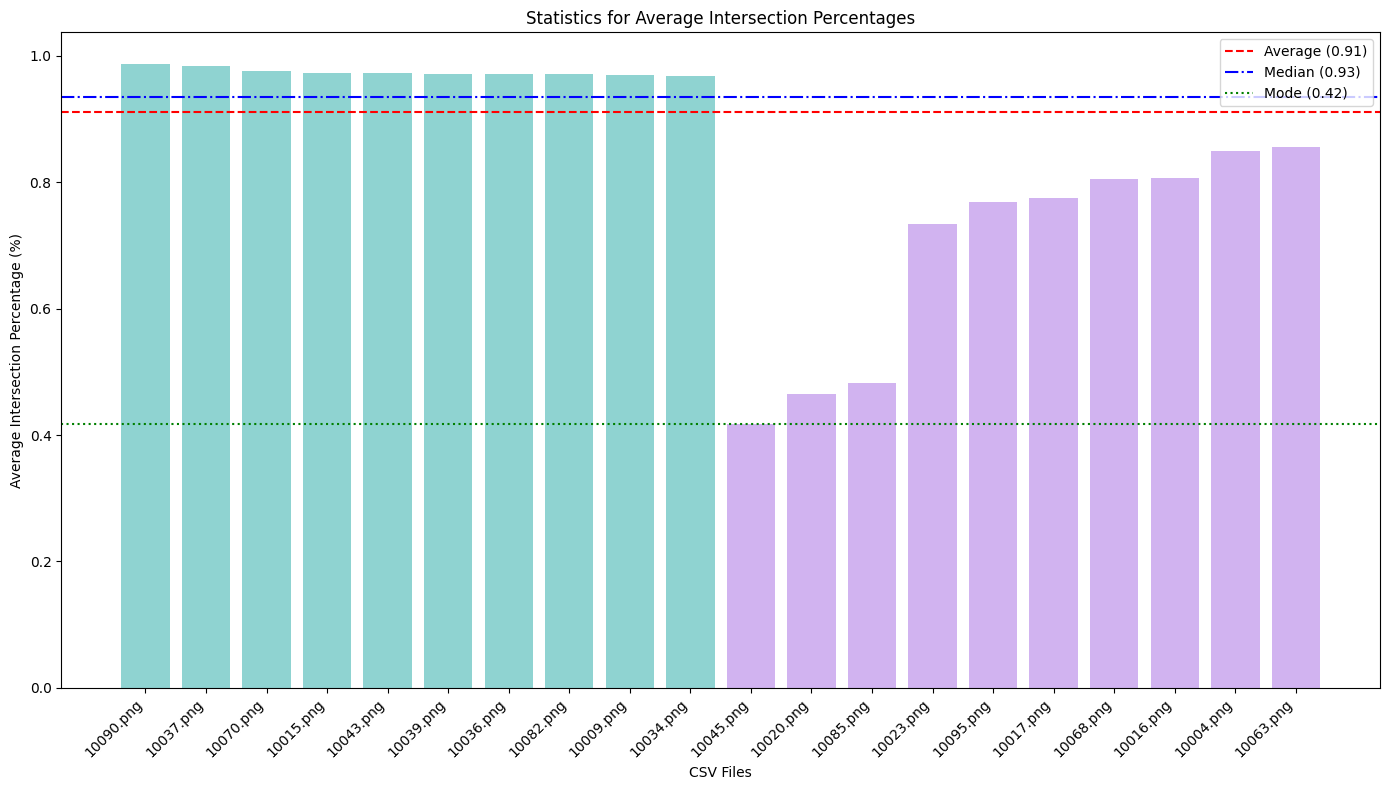

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Process intersection area ratio results into a DataFrame
def process_intersection_ratios(results):
    """
    Process results to calculate the intersection area ratio for each file.
    """
    data = []
    for result in results:
        file_name = result["file"]
        avg_intersection_ratio = np.mean([obj.get("intersection_ratio", 0) for obj in result["objects"]])
        data.append({
            "File": file_name,
            "intersection_ratio": avg_intersection_ratio
        })
    return pd.DataFrame(data)

# Identify statistics for intersection area ratios
def identify_statistics_intersection(df, metric):
    """
    Identify statistical measures for intersection area ratios.
    """
    top_10_highest = df.nlargest(10, metric)
    top_10_lowest = df.nsmallest(10, metric)
    median_value = df[metric].median()
    avg_value = df[metric].mean()
    mode_value = df[metric].mode().iloc[0] if not df[metric].mode().empty else None
    return top_10_highest, top_10_lowest, avg_value, median_value, mode_value

# Visualize intersection ratios
def visualize_intersection_ratios(df, save_dir, dataset):
    """
    Visualize statistics for intersection area ratios.
    """
    metric = "intersection_ratio"
    top_10_high, top_10_low, avg_value, median_value, mode_value = identify_statistics_intersection(df, metric)

    plt.figure(figsize=(14, 8))
    combined = pd.concat([top_10_high, top_10_low])
    labels = combined["File"]
    values = combined[metric]
    colors = ['#8fd3d1'] * len(top_10_high) + ['#d1b3f0'] * len(top_10_low)

    plt.bar(labels, values, color=colors)
    plt.axhline(avg_value, color='red', linestyle='--', label=f'Average ({avg_value:.2f})')
    plt.axhline(median_value, color='blue', linestyle='-.', label=f'Median ({median_value:.2f})')
    if mode_value is not None:
        plt.axhline(mode_value, color='green', linestyle=':', label=f'Mode ({mode_value:.2f})')

    plt.xlabel("CSV Files")
    plt.ylabel("Average Intersection Percentage (%)")
    plt.title("Statistics for Average Intersection Percentages")
    plt.xticks(rotation=45, ha="right")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f"{save_dir}/yolo_{dataset}_intersection_ratios.png", dpi=300)
    plt.show()

# Process results into a DataFrame
df = process_intersection_ratios(results)

# Visualize the statistics
visualize_intersection_ratios(df, save_dir, dataset)


# Visualize One File

In [ ]:
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import os

def draw_combined_visualization_with_black_canvas(model_path, image_path, data_2d_path):
    # Load the YOLO model and perform inference
    model = YOLO(model_path)
    results = model(image_path)[0]

    # Load the image
    img = Image.open(image_path)
    width, height = img.size
    font = ImageFont.load_default()

    # Create a black canvas
    black_canvas = Image.new("RGB", (width, height), "black")
    draw_img = ImageDraw.Draw(img)
    draw_black = ImageDraw.Draw(black_canvas)

    # --- YOLO Predictions ---
    for result in results:
        # Bounding box in xyxy format
        box = result.boxes.xyxy[0]
        x1, y1, x2, y2 = map(int, box)
        center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

        # Draw YOLO bounding box in red
        for draw in [draw_img, draw_black]:
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
            draw.ellipse([center_x - 3, center_y - 3, center_x + 3, center_y + 3], fill="red", outline="red")

        # YOLO keypoints
        keypoints = result.keypoints.xy.tolist() if result.keypoints else []
        if keypoints:
            keypoints = [(int(x), int(y)) for x, y in keypoints[0] if x != 0 and y != 0]
            for i, (x, y) in enumerate(keypoints[:8]):  # Limit to 8 keypoints
                for draw in [draw_img, draw_black]:
                    draw.ellipse([x - 3, y - 3, x + 3, y + 3], fill="red", outline="red")
                    draw.text((x + 5, y + 5), str(i), fill="white", font=font)

            # Connect YOLO keypoints in orange
            top_square = keypoints[:4]
            bottom_square = keypoints[4:8]
            for i in range(4):
                for draw in [draw_img, draw_black]:
                    draw.line([top_square[i], top_square[(i + 1) % 4]], fill="orange", width=2)
                    draw.line([bottom_square[i], bottom_square[(i + 1) % 4]], fill="orange", width=2)
                    draw.line([top_square[i], bottom_square[i]], fill="orange", width=2)

    # --- 2D Data from File ---
    if os.path.exists(data_2d_path):
        df = pd.read_csv(data_2d_path, header=None)
        for _, row in df.iterrows():
            # Bounding box from 2D data
            center_x = row[1] * width
            center_y = row[2] * height
            bbox_width = row[3] * width
            bbox_height = row[4] * height

            top_left_x = center_x - (bbox_width / 2)
            top_left_y = center_y - (bbox_height / 2)
            bottom_right_x = center_x + (bbox_width / 2)
            bottom_right_y = center_y + (bbox_height / 2)

            # Draw 2D bounding box in blue
            for draw in [draw_img, draw_black]:
                draw.rectangle([top_left_x, top_left_y, bottom_right_x, bottom_right_y], outline="blue", width=2)
                draw.ellipse([center_x - 3, center_y - 3, center_x + 3, center_y + 3], fill="blue", outline="blue")

            # Corner points from 2D data
            corner_points = [(row[i] * width, row[i + 1] * height) for i in range(5, 20, 2)]
            for i, (x, y) in enumerate(corner_points):
                for draw in [draw_img, draw_black]:
                    draw.ellipse([x - 3, y - 3, x + 3, y + 3], fill="blue", outline="blue")
                    draw.text((x + 5, y + 5), str(i), fill="white", font=font)

            # Connect 2D keypoints in green
            top_square = corner_points[:4]
            bottom_square = corner_points[4:]
            for i in range(4):
                for draw in [draw_img, draw_black]:
                    draw.line([top_square[i], top_square[(i + 1) % 4]], fill="green", width=2)
                    draw.line([bottom_square[i], bottom_square[(i + 1) % 4]], fill="green", width=2)
                    draw.line([top_square[i], bottom_square[i]], fill="green", width=2)
    else:
        print(f"2D data file not found at {data_2d_path}. Skipping.")

    # Save and show both images
    # img.save(output_image_path)
    # black_canvas.save(black_canvas_path)
    img.show()
    black_canvas.show()

    output_image_path = os.path.join(save_dir, f"yolo_{dataset}_combined_visualization_{file_name}.png")
    black_canvas_path = os.path.join(save_dir, f"yolo_{dataset}_combined_visualization_black_{file_name}.png")

    print(f"Annotated image saved to {output_image_path}")
    print(f"Black canvas visualization saved to {black_canvas_path}")
    
    img.save(output_image_path)
    black_canvas.save(black_canvas_path)

# Example usage
file_name = '10050'
image_path = f'C:/Users/sakar/OneDrive/mt-datas/synthetic_data/12_yoro_dataset/images/test/{file_name}.png'
data_2d_path = f'C:/Users/sakar/OneDrive/mt-datas/synthetic_data/12_yoro_dataset/2d_data/{file_name}.csv'

draw_combined_visualization_with_black_canvas(model_path, image_path, data_2d_path)
